# Comparing numerical bound vs Halton sampling
We compare the dispersion indicated by VC-theory (Blumer's bound) and dispersion bound mentioned by Niedrietter and Mitchell.
We do this specifically for Halton sampling, because these sampling sequences is not determined by a maximal $N$. The other common sequences used in motion-planning follow the Halton result up to constants (e.g. Hammersley's adjustment to Halton). NOTE: we are ommitting $(t, s)$-sequences/$b$-ary net-related sets/sequences at the moment since they are not naturally incremental, and they do in fact have stronger leading coefficients on the dispersion bound.

These experiments are going to be run with dispersions in the unit cube $[0, 1]^d$.

From Mitchell, we acquire the following bound:
$$
d_N(HALT) < \left[ R_1^4 + \sum_{i=2}^s R_i^2 \right]^{1/2} N^{-1/s}, \forall N \geq \prod_{i=1}^s R_i
$$

Where $R_i$'s are the relatively prime bases used for the Halton sampling sequence. Janson said prime... we'll use the first $n$ from `sympy`. 

In [2]:
from nbformat.json_compat import get_current_validator

from bound import compute_ss_comb_sum
from nonasymptotic.bound import compute_vol_unit_sphere, doubling_sample_search_over_log2_prob_bound, compute_sauer_shelah_bound_log2

import sympy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# What we want: a plot of desired discrepancy vs. number of points for Halton and Blumer's proof technique at varying levels of probability.
d=2
n_curve_points = 1000

In [4]:
# compute the Halton discrepancy bound
max_samples = 1e12
sp.sieve.extend_to_no(d)
halton_bases = np.array(sp.sieve._list[:d])

halton_constant = np.sqrt(halton_bases[0] ** 4 + np.sum(halton_bases[1:] ** 2))
min_halton_N = np.prod(halton_bases)

halton_n_samples = np.arange(min_halton_N, max_samples, step=(max_samples - min_halton_N) / n_curve_points)
halton_dispersion = halton_constant * (halton_n_samples ** (-1 / d))

In [5]:
# compute the Sauer-Shelah discrepancy bound with the indicated probability

# start at the cube diagonal (the largest possible dispersion, and then scale down to the smallest dispersion of halton)
success_probs = np.array([0.1, 0.3, 0.7, 0.9, 0.95])
blumer_dispersion = np.linspace(0.5, halton_dispersion[-1], num=n_curve_points)
rhos = compute_vol_unit_sphere(d) * blumer_dispersion ** d
blumer_n_samples = np.array([
    [doubling_sample_search_over_log2_prob_bound(lambda _m : compute_sauer_shelah_bound_log2(_m, _rho, d + 1), _success_prob)
     for _rho in rhos] for _success_prob in success_probs
])


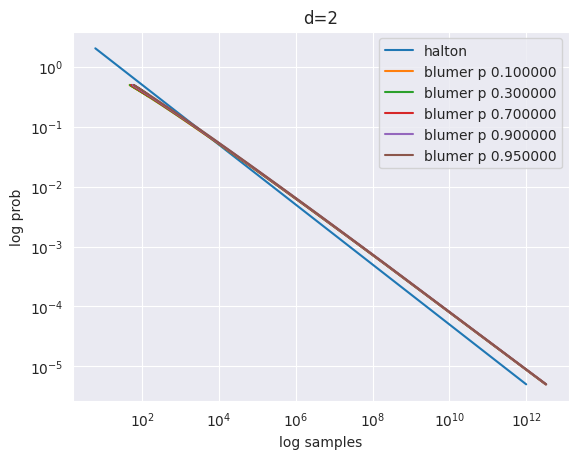

In [6]:
plt.figure()
plt.plot(halton_n_samples, halton_dispersion, label='halton')
for i in range(len(success_probs)):
    plt.plot(blumer_n_samples[i], blumer_dispersion, label='blumer p %f' % success_probs[i])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('log prob')
plt.xlabel('log samples')
plt.title('d=2')
plt.plot()
plt.legend()
plt.show()

# Comparing the Numerical Bound vs. Blumer's Bound (at face value)

This is a comparison of the numerical search using the lowest-order term using VC theory against the Blumer's statement of his bound. We'll also be using the figure we generate here in the paper.

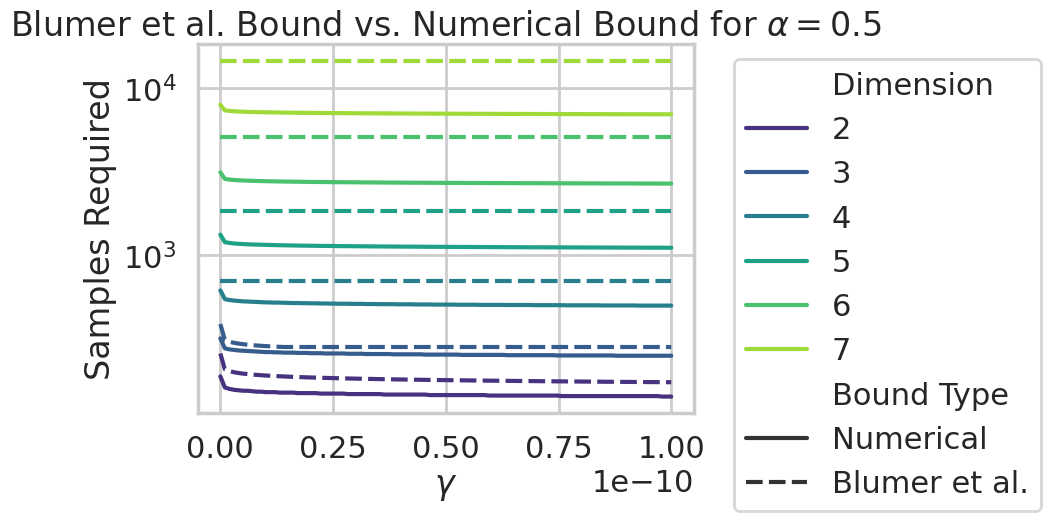

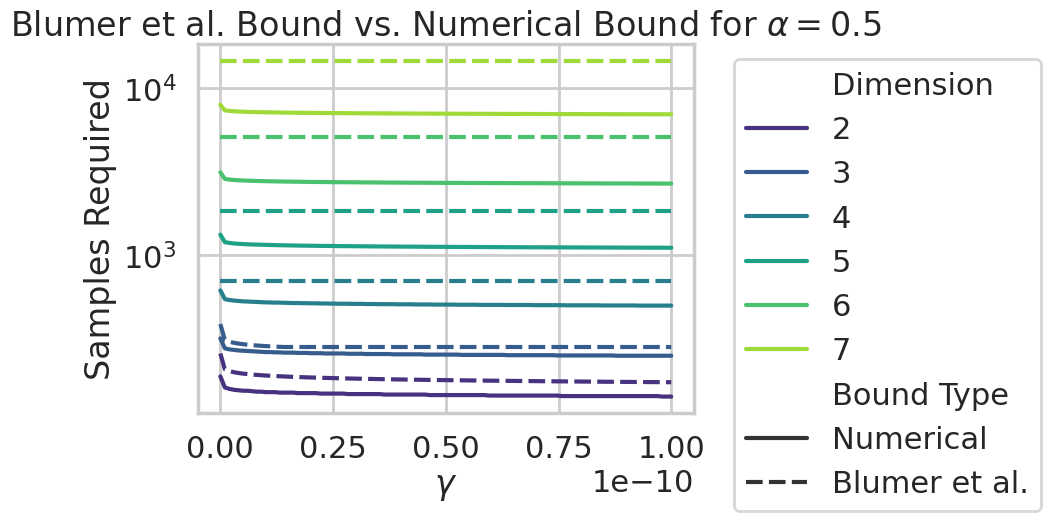

In [6]:
# this is blumer's bound verbatum
def blumer_bound(eps, gamma, vc_dim):
    return np.maximum(4 / eps * np.log2(2 / gamma), 8 * vc_dim / eps * np.log2(13 / eps))
    # return np.maximum(4 / eps * np.log(2 / gamma))
#     return 8 * vc_dim / eps * np.log(13 / eps)

probs = np.linspace(1e-10, 1e-15, num=100)
dims = [2, 3, 4, 5,6, 7]
rad = 0.5

results_record = {
    'Dimension': [],
    'probs': [],
    'n_samples': [],
    'Bound Type': []
}

for dim in dims:
    eps = compute_vol_unit_sphere(dim) * (rad ** dim)
    numer_samples = np.zeros_like(probs)
    
    for i_p, _p in enumerate(probs):
        numer_samples[i_p] = doubling_sample_search_over_log2_prob_bound(
            lambda _m : compute_sauer_shelah_bound_log2(_m, eps, dim + 1), 1 - _p
        )
        
    results_record['probs'] = np.concatenate([results_record['probs'], probs])
    results_record['n_samples'] = np.concatenate([results_record['n_samples'], numer_samples])
    results_record['Bound Type'] = np.concatenate([results_record['Bound Type'], ['Numerical'] * len(probs)])
    results_record['Dimension'] = np.concatenate([results_record['Dimension'], [str(dim)] * len(probs)])
    
    
    blumer_samples = blumer_bound(eps, probs, dim + 1)
    results_record['probs'] = np.concatenate([results_record['probs'], probs])
    results_record['n_samples'] = np.concatenate([results_record['n_samples'], blumer_samples])
    results_record['Bound Type'] = np.concatenate([results_record['Bound Type'], ['Blumer et al.'] * len(probs)])
    results_record['Dimension'] = np.concatenate([results_record['Dimension'], [str(dim)] * len(probs)])
    
    numer_samples = np.zeros_like(blumer_samples)
    

results_df = pd.DataFrame(results_record)
sns.set_theme(style='whitegrid', context='poster')
ax = sns.lineplot(data=results_df, x='probs', y='n_samples', hue='Dimension', style='Bound Type', palette='viridis')
ax.set_yscale('log')
ax.set_xlabel('$\gamma$')
ax.set_ylabel('Samples Required')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1))
ax.set_title('Blumer et al. Bound vs. Numerical Bound for $\\alpha=0.5$')
ax.ticklabel_format(axis='x', scilimits=(0, 0))

plt.savefig('blumer_numer.pdf', format='pdf', bbox_inches='tight')
plt.show()


## Arbitrary-precision arithmetic to really check if the curve-cross for $d=2$ is a numerical issue:

First, we reimplement the numerical algorithm using the `Decimal` class so we can set the number of significant digits (at the cost of memory).

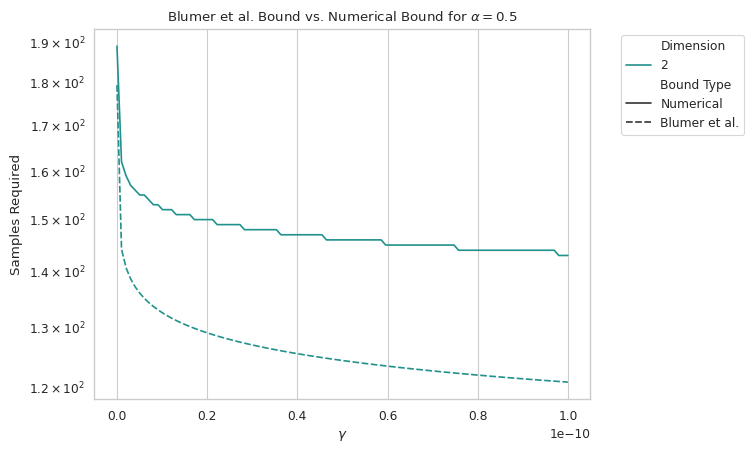

In [53]:
from decimal import getcontext, Decimal
import decimal
import math

getcontext().prec = 100
volume_half_rad_ball = Decimal(math.pi) / 4 # may need more precision here and may use a convergent sum
conversion_factor = Decimal('2').ln()
sample_constant = volume_half_rad_ball / 2 * conversion_factor

def blumer_bound_decimal(gamma):
    return  ((4 / volume_half_rad_ball) * (2 / gamma).ln()).max(
        (8 * 3 / volume_half_rad_ball) * (13 / volume_half_rad_ball).ln())
    

def compute_sauer_shelah_bound_d2_ln_decimal(m_samples):
    ss_comb_sum = Decimal(compute_ss_comb_sum(m_samples, 3))
    return ss_comb_sum.ln() - sample_constant * m_samples + conversion_factor


def doubling_sample_search_over_ln_prob_bound_decimal(samples_to_ln_prob, failure_prob):
    """
    :param samples_to_ln_prob: A function that consumes an integer number of samples
    and outputs a probability as a Decimal object.
    :param failure_prob: Probability for random construction to fail, expressed as a Decimal object.
    :return: Number of samples required to meet success probability.
    """
    # we're exploiting the monotonicity of the increase/decrease behavior of
    # the probability bound.
    sample_out_limit = 10 ** 3000
    
    log_failure_prob = failure_prob.ln()

    m_samples_lb = 1
    m_samples_ub = 2
    while True:
        cand_gamma = samples_to_ln_prob(m_samples_ub)
        next_gamma = samples_to_ln_prob(m_samples_ub + 1)

        # move past the desired probability and ensure we are 'downhill'
        if log_failure_prob >= cand_gamma >= next_gamma:
            break

        m_samples_ub *= 2

        if m_samples_ub > sample_out_limit:
            raise OverflowError("Reached sample threshold for useful computation.")

    # next, binary search down to the right number of samples.
    while True:
        if m_samples_ub == m_samples_lb + 1:
            return m_samples_ub
        elif m_samples_ub <= m_samples_lb:
            raise ArithmeticError('Something wrong happened.')

        test_samples = int((m_samples_lb + m_samples_ub) / 2)
        # test if the tester is the sample count we're looking for
        cand_gamma = samples_to_ln_prob(test_samples)
        next_gamma = samples_to_ln_prob(test_samples + 1)

        # if the candidate failure probability is still too high, or
        # if we're not going 'downhill' yet, then move up the lower bound.
        if cand_gamma > log_failure_prob or next_gamma > cand_gamma:
            m_samples_lb = test_samples

        # otherwise, move down the upper bound
        else:
            m_samples_ub = test_samples

doubling_sample_search_over_ln_prob_bound_decimal(
    compute_sauer_shelah_bound_d2_ln_decimal,
    Decimal('0.5')
)

probs = np.linspace(1e-10 , 1e-15, num=100)
results_record = {
    'Dimension': [],
    'probs': [],
    'n_samples': [],
    'Bound Type': []
}

numer_samples = np.zeros_like(probs)
for i_p, _p in enumerate(probs):
    _p = Decimal(_p.item())
    numer_samples[i_p] = doubling_sample_search_over_ln_prob_bound_decimal(
        lambda _m : compute_sauer_shelah_bound_d2_ln_decimal(_m), _p
    )

results_record['probs'] = np.concatenate([results_record['probs'], probs])
results_record['n_samples'] = np.concatenate([results_record['n_samples'], numer_samples])
results_record['Bound Type'] = np.concatenate([results_record['Bound Type'], ['Numerical'] * len(probs)])
results_record['Dimension'] = np.concatenate([results_record['Dimension'], [str(2)] * len(probs)])

blumer_samples = blumer_bound(float(volume_half_rad_ball), probs, 2 + 1) # NOTE: the numerical issue could also be numpy on blumer?
results_record['probs'] = np.concatenate([results_record['probs'], probs])
results_record['n_samples'] = np.concatenate([results_record['n_samples'], blumer_samples])
results_record['Bound Type'] = np.concatenate([results_record['Bound Type'], ['Blumer et al.'] * len(probs)])
results_record['Dimension'] = np.concatenate([results_record['Dimension'], [str(2)] * len(probs)])
numer_samples = np.zeros_like(blumer_samples)


results_df = pd.DataFrame(results_record)
sns.set_theme(style='whitegrid', context='paper')
ax = sns.lineplot(data=results_df, x='probs', y='n_samples', hue='Dimension', style='Bound Type', palette='viridis')
ax.set_yscale('log')
ax.set_xlabel('$\gamma$')
ax.set_ylabel('Samples Required')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1))
ax.set_title('Blumer et al. Bound vs. Numerical Bound for $\\alpha=0.5$')
ax.ticklabel_format(axis='x', scilimits=(0, 0))

plt.show()



Conclusion: it's probably not precision.
After reading Blumer's proof, turns out when they write $\log$, they mean 'logarithm base 2.'